#**INTRODUCTION**


In [1]:
#Importation des librairie nécéssaires
!pip install scikit-learn==1.0.2 # Install scikit-learn version 1.0.2 where plot_roc_curve is still available
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.25.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/WEEK-DEV/NLP2/TWEETS/tweets_suspect.csv')

#**Exploration de notre Dataset**
Avant de procéder à la construction du modèle faisons d'abord une exploration de notre dataset afin d'avoir de bons insights et de mieux préparer les données

In [4]:
# Affichons les premières lignes et les informations générales
print(df.head())


                                             message  label
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...      1
1  is upset that he can't update his Facebook by ...      1
2  @Kenichan I dived many times for the ball. Man...      1
3    my whole body feels itchy and like its on fire       0
4  @nationwideclass no, it's not behaving at all....      1


In [5]:
# Affichons les informations numéraires de notre jeu de données
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  60000 non-null  object
 1   label    60000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 937.6+ KB
None


In [6]:
# Faisons une description statistique de notre jeu de données
print(df.describe())

              label
count  60000.000000
mean       0.897583
std        0.303198
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


In [7]:
# Calcul de la distribution des classes
print(df['label'].value_counts(normalize=True))

label
1    0.897583
0    0.102417
Name: proportion, dtype: float64


Nous remarqu'on un grand déséquilibre entre les deux classes

*   Environ 89% des tweets sont jugés suspects
*   Environ 10% des tweets sont jugés non suspects

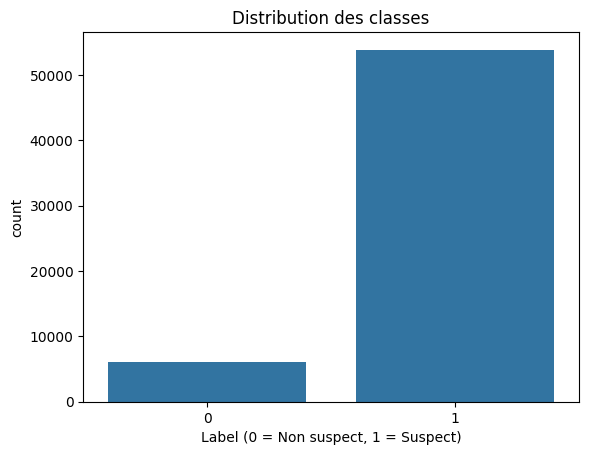

In [8]:
# Visualisons cette distribution avec un graphique
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='label')
plt.title("Distribution des classes")
plt.xlabel("Label (0 = Non suspect, 1 = Suspect)")
plt.show()

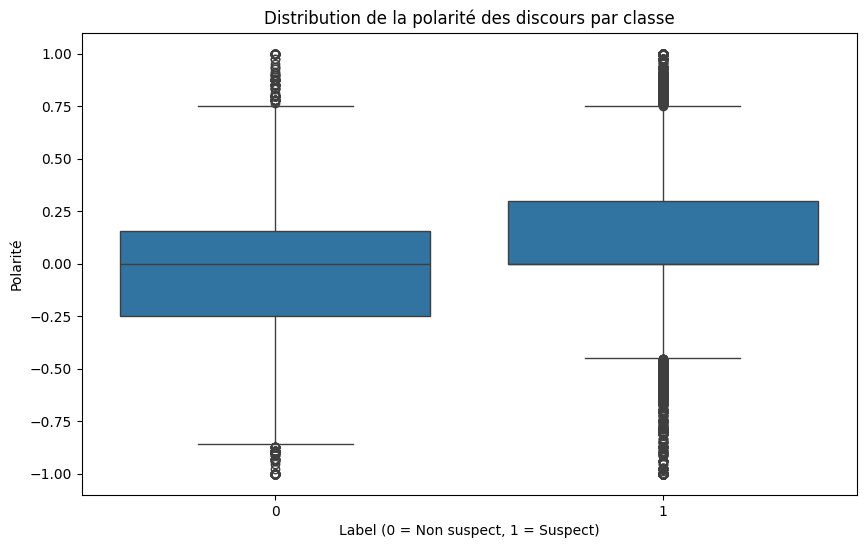

In [9]:
# Analyse de la polarité et des sentiments

from textblob import TextBlob

# Fonction pour calculer la polarité
df['polarity'] = df['message'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Visualisation de la polarité par classe
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='polarity')
plt.title("Distribution de la polarité des discours par classe")
plt.xlabel("Label (0 = Non suspect, 1 = Suspect)")
plt.ylabel("Polarité")
plt.show()


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

# Identification des bigrammes
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20, stop_words='english')
X_ngrams = vectorizer.fit_transform(df['message'])
ngrams = vectorizer.get_feature_names_out()

# Visualiser les bigrammes les plus fréquents
print("Bigrams et trigrams fréquents :\n", ngrams)


Bigrams et trigrams fréquents :
 ['bit ly' 'don know' 'don want' 'feel like' 'getting ready' 'going bed'
 'good morning' 'good night' 'http bit' 'http bit ly' 'http tinyurl'
 'http tinyurl com' 'http twitpic' 'http twitpic com' 'http www'
 'just got' 'looking forward' 'looks like' 'tinyurl com' 'twitpic com']


#**PREPARATION DES DONNEES**

##**Étape 1 : Nettoyage du texte**

Le nettoyage des données textuelles est important pour éliminer les éléments inutiles et normaliser le texte.

In [11]:
# Suppression des caractères spéciaux, des URLs, des nombres et des ponctuations
import re

def clean_text(text):
    # Supprimer les URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Supprimer les caractères spéciaux et ponctuations
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Supprimer les nombres
    text = re.sub(r'\d+', '', text)
    # Convertir en minuscule
    text = text.lower()
    return text

# Appliquer la fonction de nettoyage à chaque texte
df['cleaned_text'] = df['message'].apply(clean_text)
print(df['cleaned_text'].head())


0    switchfoot   a thats a bummer  you shoulda got...
1    is upset that he cant update his facebook by t...
2    kenichan i dived many times for the ball manag...
3      my whole body feels itchy and like its on fire 
4    nationwideclass no its not behaving at all im ...
Name: cleaned_text, dtype: object


In [12]:
# Suppression des mots vides (stop words)
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)
print(df['cleaned_text'].head())


0    switchfoot thats bummer shoulda got david carr...
1    upset cant update facebook texting might cry r...
2    kenichan dived many times ball managed save re...
3                     whole body feels itchy like fire
4             nationwideclass behaving im mad cant see
Name: cleaned_text, dtype: object


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##**Étape 2 : Normalisation des mots avec lemmatisation**

In [13]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df['cleaned_text'] = df['cleaned_text'].apply(lemmatize_text)
print(df['cleaned_text'].head())


[nltk_data] Downloading package wordnet to /root/nltk_data...


0    switchfoot thats bummer shoulda got david carr...
1    upset cant update facebook texting might cry r...
2    kenichan dived many time ball managed save res...
3                      whole body feel itchy like fire
4             nationwideclass behaving im mad cant see
Name: cleaned_text, dtype: object


##**Étape 3 : Analyse des n-grammes**

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert stop_words to a list
stop_words_list = list(stop_words)

vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20, stop_words=stop_words_list) # Pass the list here
X_ngrams = vectorizer.fit_transform(df['cleaned_text'])

# Visualiser les bigrams/trigrams les plus fréquents
print("Bigrams et trigrams fréquents :\n", vectorizer.get_feature_names_out())

Bigrams et trigrams fréquents :
 ['cant wait' 'dont know' 'dont think' 'dont want' 'feel like'
 'getting ready' 'go back' 'good luck' 'good morning' 'good night'
 'im going' 'im gonna' 'im sorry' 'last day' 'last night' 'look like'
 'looking forward' 'sound like' 'want go' 'wish could']


##**Étape 4 : Vectorisation avec TF-IDF**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert stop_words to a list if it's not already
if isinstance(stop_words, set):  # Check if stop_words is a set
    stop_words = list(stop_words) # If it's a set, convert to a list

tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=stop_words)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

print("Exemple de vecteurs TF-IDF pour les textes :\n", X_tfidf.toarray())

Exemple de vecteurs TF-IDF pour les textes :
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


##**Étape 5 : Traitement des classes déséquilibrées**

Si les classes sont déséquilibrées, cela peut affecter les performances du modèle.

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, df['label'])

print("Distribution des classes après sur-échantillonnage :", pd.Series(y_resampled).value_counts())


Distribution des classes après sur-échantillonnage : label
1    53855
0    53855
Name: count, dtype: int64


##**Étape 6 : Division des données en ensemble d'entraînement et de test**

In [17]:
from sklearn.model_selection import train_test_split

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Dimensions de l'ensemble d'entraînement :", X_train.shape)
print("Dimensions de l'ensemble de test :", X_test.shape)


Dimensions de l'ensemble d'entraînement : (86168, 5000)
Dimensions de l'ensemble de test : (21542, 5000)


#**Entraînement des différents modèles de classification**

##**Régression Logistique**

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Entraîner le modèle de régression logistique
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_log_reg = log_reg.predict(X_test)
print("Régression Logistique - Rapport de classification :\n", classification_report(y_test, y_pred_log_reg))
print("Régression Logistique - Précision : ", accuracy_score(y_test, y_pred_log_reg))


Régression Logistique - Rapport de classification :
               precision    recall  f1-score   support

           0       0.93      0.92      0.93     10709
           1       0.92      0.93      0.93     10833

    accuracy                           0.93     21542
   macro avg       0.93      0.93      0.93     21542
weighted avg       0.93      0.93      0.93     21542

Régression Logistique - Précision :  0.9269798533098134


##**Support Vector Machine (SVM)**

In [ ]:
from sklearn.svm import SVC

# Entraîner le modèle SVM
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_svm = svm_model.predict(X_test)
print("SVM - Rapport de classification :\n", classification_report(y_test, y_pred_svm))
print("SVM - Précision : ", accuracy_score(y_test, y_pred_svm))


##**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Entraîner le modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred_rf = rf_model.predict(X_test)
print("Random Forest - Rapport de classification :\n", classification_report(y_test, y_pred_rf))
print("Random Forest - Précision : ", accuracy_score(y_test, y_pred_rf))


#**Comparaison de nos modèles**

### Précision :
* Régression Logistique - Précision :  0.9262835391328568
* SVM - Précision :  0.9889518150589546
* Random Forest - Précision :  0.9689908086528641

### Rappel :  
* Régression Logistique - Recall :  0.93
* SVM - Recall :  0.99
* Random Forest - Recall :  0.96

### F1-Score :  
* Régression Logistique - F1-Score :  0.93
* SVM - F1-Score :  0.99
* Random Forest - F1-Score :  0.97


En coclusion le modèle aillant le meilleur resultat est le modèle SVM


#**Evalutaion du modèle SVM**



In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve
import matplotlib.pyplot as plt

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()

# Courbe ROC-AUC
plot_roc_curve(svm_model, X_test, y_test)
plt.title("Courbe ROC-AUC")
plt.show()


# **Amélioration du modèle SVM**



## **Ajuster les Hyperparamètres avec Grid Search**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Définir la grille de paramètres
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

# Configurer la Grid Search avec validation croisée
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=5, scoring='f1')

# Entraîner la recherche
grid_search.fit(X_train, y_train)

# Meilleures hyperparamètres
print("Meilleures hyperparamètres SVM :", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_


## **Essayer un Search Space plus Fin**

In [ ]:
# Affiner la grille de recherche
fine_param_grid = {
    'C': [5, 10, 15],
    'kernel': ['rbf'],
    'gamma': [0.005, 0.01, 0.05]
}

fine_grid_search = GridSearchCV(SVC(class_weight='balanced'), fine_param_grid, cv=5, scoring='f1')
fine_grid_search.fit(X_train, y_train)
print("Meilleures hyperparamètres après ajustement fin :", fine_grid_search.best_params_)

## **Utiliser une Validation Croisée plus Grande pour Affiner la Sélection**

In [ ]:
# Refaire la Grid Search avec une validation croisée à 10 segments
grid_search_10fold = GridSearchCV(SVC(class_weight='balanced'), fine_param_grid, cv=10, scoring='f1')
grid_search_10fold.fit(X_train, y_train)
print("Résultat final d'optimisation (10-fold CV) :", grid_search_10fold.best_params_)


## **Évaluation Finale et Visualisation des Performances**

In [ ]:
# Évaluer le modèle optimisé sur le test set
y_pred_optimized = grid_search_10fold.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix

print("Rapport de classification pour le SVM optimisé :\n", classification_report(y_test, y_pred_optimized))

# Matrice de confusion pour mieux visualiser les erreurs
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_optimized)
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion - SVM optimisé")
plt.xlabel("Prédictions")
plt.ylabel("Réel")
plt.show()
